In [1]:
# This notebook has to be in tudataset/tud_benchmark

# This means that you have to first download the TUDataset Repository e.g. with
# git clone https://github.com/chrsmrrs/tudataset.git

# Exploratory Data Analysis - Getting started

We assume that you have the generated Gram matrices and sparse vectors in the directories

> kernels/node_labels

> kernels/without_labels

If not you can download them [here](https://ucloud.univie.ac.at/index.php/s/E3YKph0jkpbw8TN).

The generated Gram matrices and sparse vectors *kernels/node_labels* use the node labels during the construction of the kernels[1] while the ones in *kernels/without_labels* use no node labels and are completely relying on the topology. 

Below we show how you can use the Gram matrices and sparse vectors that we provided to get started with your exploratory data analysis.





[1]: Except for the IMBD-Binary data set, which only has a representation without using the node labels.


In [2]:
# #Install pytorch geometric: https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html

# #Here is the gpu cuda installation, for the cpu version replace cu102 with cpu
# ! pip install torch-scatter==latest+cu102 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
# ! pip install torch-sparse==latest+cu102 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
# ! pip install torch-cluster==latest+cu102 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
# ! pip install torch-spline-conv==latest+cu102 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
# ! pip install torch-geometric

In [3]:
import os
import numpy as np
from auxiliarymethods import datasets as dp
from auxiliarymethods.reader import tud_to_networkx
import pandas as pd
from sklearn.decomposition import KernelPCA, TruncatedSVD
from matplotlib import pyplot as plt
from nrkmeans import NrKmeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score
import seaborn as sns
from scipy.sparse import load_npz
import auxiliarymethods.auxiliary_methods as aux
import networkx as nx
from sklearn.cluster import KMeans
from copy import deepcopy

In [4]:
# utility functions
def load_csv(path):
    return np.loadtxt(path, delimiter=";")

def load_sparse(path):
    return load_npz(path)

def select_from_list(l, indices):
    return [l[i] for i in indices]

## Overview of NMI performance for different representations

### KPCA
Applied [Kernel PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html) with the provided Gram matrix and then clustered the reduced representation with Subkmeans with $k=$'number of ground truth classes'.


### SVD
Applied [Truncated SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) a version of SVD that can handle sparse feature matrices and then clustered the reduced representation with Subkmeans with $k=$'number of ground truth classes'.

### Spectral Clustering
Applied [Spectral Clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html), an algorithm that is often used to cluster graph data, with the similarities provided by the Gram matrices and with $k=$'number of ground truth classes'. In contrast to Subkmeans Spectral Clustering can find arbitrarily shaped clusters.

#################node_labels#################


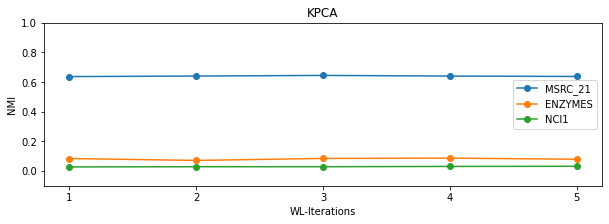

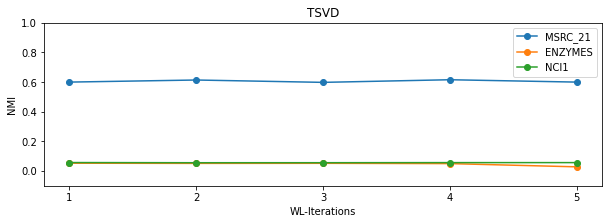

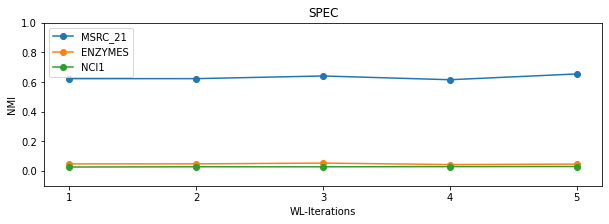

#################without_labels#################


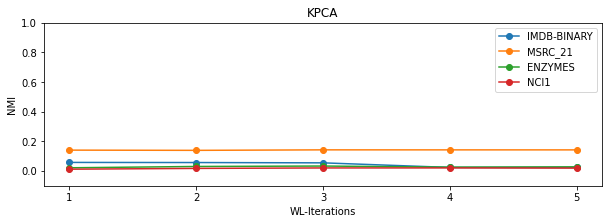

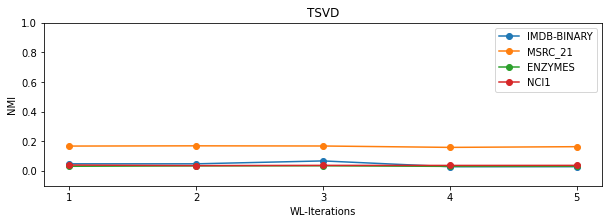

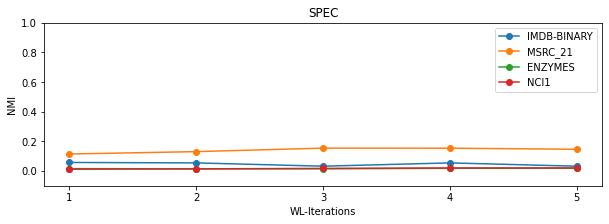

In [5]:
result_names = ["KPCA", "TSVD", "SPEC"]
for version in ["node_labels", "without_labels"]:
    print(f"#################{version}#################")
    for name_i in result_names:
        path_i = os.path.join("../../graph_representations", version, name_i+".csv")
        nmi_df = pd.read_csv(path_i, index_col=0)
        fig, ax = plt.subplots(figsize=(10,3))
        ax.set_ylabel("NMI")
        ax.set_xlabel("WL-Iterations")
        ax.set_ylim([-0.1,1])
        ax.set_xticks([0,1,2,3,4])
        ax.set_xticklabels([1,2,3,4,5])
        ax.set_title(name_i)
        nmi_df.plot(marker="o", ax=ax)
        plt.show();

## Example usage for gram matrix and sparse matrix with Weisfeiler-Lehman kernel

For the other kernels this works the same.

In [6]:
# # This code was used to get the results for each data set above:
# # Get some initial results for each data set
# # This will plot all representations and cluster these with Spectral Clustering and Subkmeans
# # In your case you might only want to run your data set

# use_edge_labels = False
# for use_labels in [True, False]:
#     if use_labels:
#         base_path = os.path.join("kernels","node_labels")
#         datasets = ["MSRC_21", "ENZYMES", "NCI1"]
#     else:
#         base_path = os.path.join("kernels","without_labels")
#         datasets = ["IMDB-BINARY","MSRC_21", "ENZYMES", "NCI1"]
#     print("Load from ", base_path)
#     nmis_kpca = {}
#     nmis_tsvd = {}
#     nmis_spec = {}

#     for dataset in datasets:
#         classes = dp.get_dataset(dataset)
#         nmis_kpca[dataset] = []
#         nmis_tsvd[dataset] = []
#         nmis_spec[dataset] = []
#         for iterations in range(1,6):
#             # 0 taking just the nodelabels themselves into account; 
#             # 1 considers nearest-neighbours, 2 one layer deeper and so on
#             # play with this parameter to create a new kernel!
#             print("##################################")
#             print("Dataset ", dataset)
#             print("Iteration ", iterations)
#             print("##################################")

#             #Gram Matrix for the Weisfeiler-Lehman subtree kernel
#             gram = load_csv(os.path.join(base_path,f"{dataset}_gram_matrix_wl{iterations}.csv"))
#             gram = aux.normalize_gram_matrix(gram)

#             #Sparse Vectors for the Weisfeiler-Lehmann subtree kernel
#             vec = load_sparse(os.path.join(base_path,f"{dataset}_vectors_wl{iterations}.npz"))
#             print(gram.shape, vec.shape)

#             tsvd = TruncatedSVD(n_components=100)
#             reduced_tsvd = tsvd.fit_transform(vec)

#             kpca = KernelPCA(n_components=100, kernel="precomputed")
#             reduced_kpca = kpca.fit_transform(gram)
            
#             k = len(set(classes.tolist()))
#             print("n_clusters: ", k)
#             d = {0:"TSVD",1:"KPCA"}
#             n_d = {0:nmis_tsvd, 1:nmis_kpca}
#             for i,rep_i in enumerate([reduced_tsvd, reduced_kpca]):
#                 print(d[i])
                
#                 fig, ax = plt.subplots(figsize=(5,5))
#                 ax.scatter(rep_i[:,0], rep_i[:,1], c=classes, s=1)
#                 plt.show();
                
#                 # Apply Subkmeans
#                 nrkm = NrKmeans(n_clusters=[k,1])#, allow_larger_noise_space=False)
#                 nrkm.fit(rep_i, best_of_n_rounds=10, verbose=False)
#                 print("Found Cluster Subspaces: ", nrkm.m)
#                 subkm_nmi = normalized_mutual_info_score(nrkm.labels[0],classes)
#                 print(f"Subkmeans NMI:{subkm_nmi:.4f}")    
#                 n_d[i][dataset].append(subkm_nmi)
#                 # Plot rotated space
#                 V = nrkm.V
#                 rotated = np.dot(rep_i,V)
#                 reduced_df = pd.DataFrame(rotated[:,0:2])
#                 reduced_df["labels"] = classes#nrkm.labels[0]
#                 sns.pairplot(reduced_df, hue="labels", diag_kind="hist")
#                 plt.show();
            
#             # Apply Spectral Clustering
#             spec = SpectralClustering(n_clusters=k, affinity="precomputed")
#             spec.fit(gram)
#             spec_nmi = normalized_mutual_info_score(spec.labels_,classes)
#             nmis_spec[dataset].append(spec_nmi)
#             print(f"Spectral  NMI:{spec_nmi:.4f}")   

#             print("##################################")

#     res = {"KPCA":nmis_kpca,"TSVD": nmis_tsvd, "SPEC": nmis_spec}
#     for key, value in res.items():
#         nmi_df = pd.DataFrame(res[key])
#         nmi_df.to_csv(os.path.join(base_path, key + ".csv"))'

## Visualize and Interpret your results

Here we use the IMDB-BINARY data set, but it works the same for all other data sets

In [7]:
def visualize(G, color=None, figsize=(5,5)):
    plt.figure(figsize=figsize)
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, 
                     pos=nx.spring_layout(G, seed=42),
                     with_labels=True,
                     node_color=color,
                     cmap="Set2")
    plt.show();

In [8]:
base_path = os.path.join("../../graph_representations", "without_labels")
ds_name = "IMDB-BINARY"
classes = dp.get_dataset(ds_name)
G = tud_to_networkx(ds_name)
print(f"Number of graphs in data set is {len(G)}")
print(f"Number of classes {len(set(classes.tolist()))}")

Number of graphs in data set is 1000
Number of classes 2


## Let's start by plotting a single graph of our data set

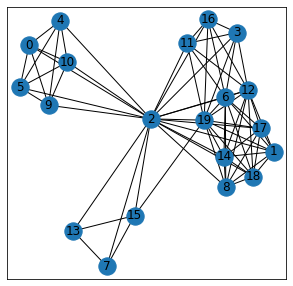

In [9]:
# We just use the first in the list
idx = 0
visualize(G[idx])

## Plot the vector representation with KernelPCA

Just by this plot we can already see that there are outliers that might disturb our K-Means assumptions

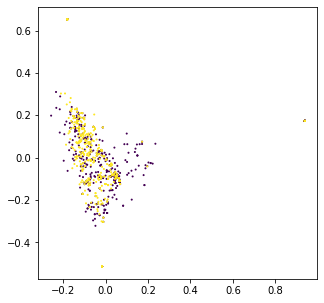

In [10]:
#Gram Matrix for the Weisfeiler-Lehman subtree kernel
iterations = 5
gram = load_csv(os.path.join(base_path,f"{ds_name}_gram_matrix_wl{iterations}.csv"))
gram = aux.normalize_gram_matrix(gram)

kpca = KernelPCA(n_components=100, kernel="precomputed")
reduced_kpca = kpca.fit_transform(gram)
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(reduced_kpca[:,0], reduced_kpca[:,1], c=classes, s=1)
plt.show();

## Plot the vector representation with TruncatedSVD

Also here we can see some outlier points. 

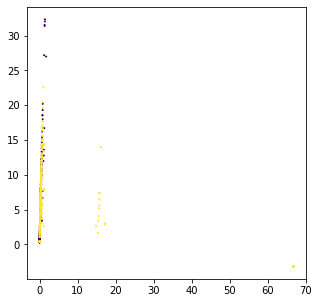

In [11]:
#Gram Matrix for the Weisfeiler-Lehman subtree kernel
iterations = 5
vec = load_sparse(os.path.join(base_path,f"{ds_name}_vectors_wl{iterations}.npz"))
tsvd = TruncatedSVD(n_components=100)
reduced_tsvd = tsvd.fit_transform(vec)

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(reduced_tsvd[:,0], reduced_tsvd[:,1], c=classes, s=1)
plt.show();

## Apply Subkmeans with KernelPCA

As expected from the results above the Subkmeans model might not be well suited to find the ground truth clusters of the IMDB-BINARY data set.

In [12]:
k = len(set(classes.tolist()))
print("n_clusters: ", k)
nrkm = NrKmeans(n_clusters=[k,1], allow_larger_noise_space=True)
nrkm.fit(reduced_kpca, best_of_n_rounds=10, verbose=False)
print("Found Cluster Subspaces: ", nrkm.m)
subkm_nmi = normalized_mutual_info_score(nrkm.labels[0],classes)
print(f"Subkmeans NMI:{subkm_nmi:.4f}")    

n_clusters:  2
Found Cluster Subspaces:  [1, 99]
Subkmeans NMI:0.0314


**Plot the rotated space**

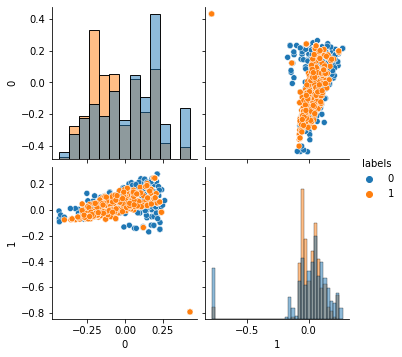

In [13]:
V = nrkm.V
rotated = np.dot(reduced_kpca,V)
reduced_df = pd.DataFrame(rotated[:,0:2])
reduced_df["labels"] = classes
sns.pairplot(reduced_df, hue="labels", diag_kind="hist")
plt.show();

## Cluster Analysis with KMeans

But, we can still use clustering to further explore the data set.
Here we use a simple technique for interpreting our cluster results for the IMBD-BINARY data set, but it works the same for the other data sets. 
We investigate the nearest neighbours of each centroid in each cluster. 

In [14]:
# only keep the first 10 components to speed up computation
reduced_kpca_10 = reduced_kpca[:, 0:10]

### First we determine the number of k clusters using a scree plot

In [15]:
costs = []
kmeans_runs = []
k_list = [1, 2, 5, 10, 15, 20, 25, 30, 35, 40]
for k in k_list:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(reduced_kpca_10)
    costs.append(kmeans.inertia_)
    kmeans_runs.append(deepcopy(kmeans))

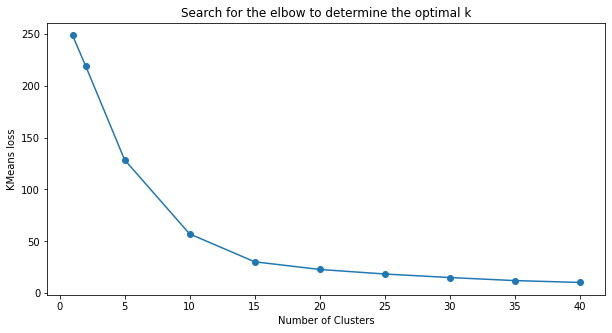

In [16]:
def scree_plot(k_list, costs):
    plt.figure(figsize=(10,5))
    plt.plot(k_list, costs, marker="o")
    plt.xlabel('Number of Clusters')
    plt.ylabel('KMeans loss')
    plt.title('Search for the elbow to determine the optimal k')
    plt.show();
scree_plot(k_list, costs)

Choose k=10

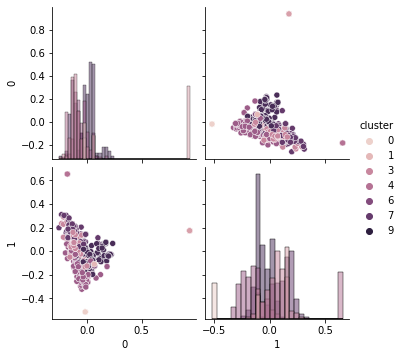

In [17]:
selected_idx = 3
kmeans = kmeans_runs[selected_idx]
df = pd.DataFrame(reduced_kpca_10[:,0:2])
df["cluster"] = kmeans.labels_
sns.pairplot(df, hue="cluster", diag_kind="hist")
plt.show();

## Plot the first n nearest neighbours of each centroid

In [18]:
from sklearn.metrics import pairwise_distances
# select first 2 nearest neighbours in for each cluster
nr_nearest = 2
nearest_indices = []
for cluster_i in set(kmeans.labels_):
    mask = (kmeans.labels_ == cluster_i)
    selection = reduced_kpca_10[mask]
    print(f"number of data points in cluster {cluster_i}: {selection.shape[0]}")
    center_i = kmeans.cluster_centers_[cluster_i].reshape(1,-1)
    distances_i = pairwise_distances(center_i, reduced_kpca_10)
    nearest_indices.append(np.argsort(distances_i, )[0][0:nr_nearest])
    print(f"Nearest data points in cluster {cluster_i}: {nearest_indices[-1]}")


number of data points in cluster 0: 24
Nearest data points in cluster 0: [723 384]
number of data points in cluster 1: 16
Nearest data points in cluster 1: [630 747]
number of data points in cluster 2: 48
Nearest data points in cluster 2: [ 54 129]
number of data points in cluster 3: 197
Nearest data points in cluster 3: [547 701]
number of data points in cluster 4: 31
Nearest data points in cluster 4: [907  95]
number of data points in cluster 5: 193
Nearest data points in cluster 5: [735 988]
number of data points in cluster 6: 17
Nearest data points in cluster 6: [563 154]
number of data points in cluster 7: 186
Nearest data points in cluster 7: [523 959]
number of data points in cluster 8: 273
Nearest data points in cluster 8: [782 114]
number of data points in cluster 9: 15
Nearest data points in cluster 9: [166 471]


Cluster 0, Indices [723 384]


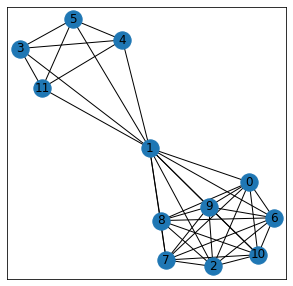

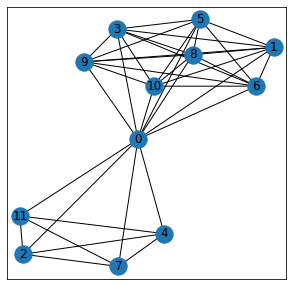

Cluster 1, Indices [630 747]


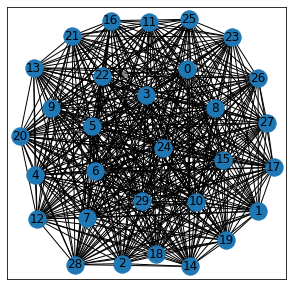

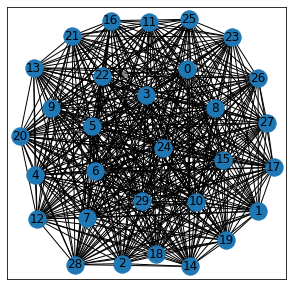

Cluster 2, Indices [ 54 129]


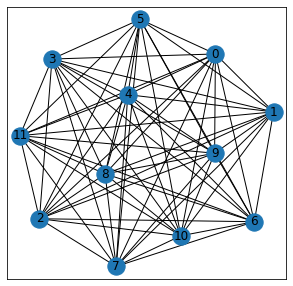

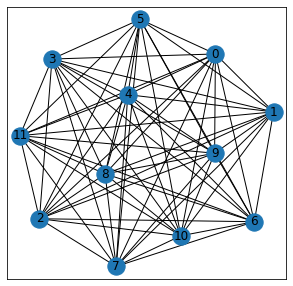

Cluster 3, Indices [547 701]


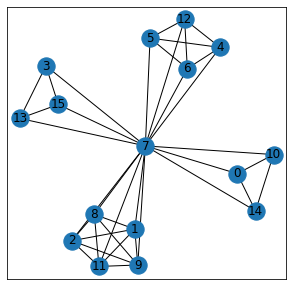

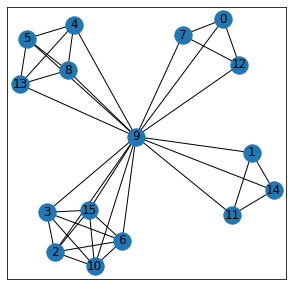

Cluster 4, Indices [907  95]


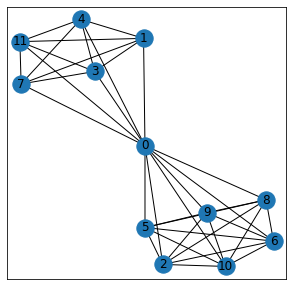

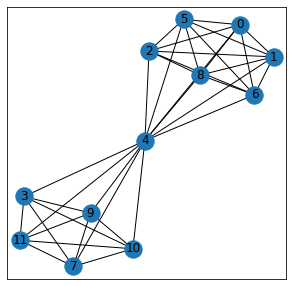

Cluster 5, Indices [735 988]


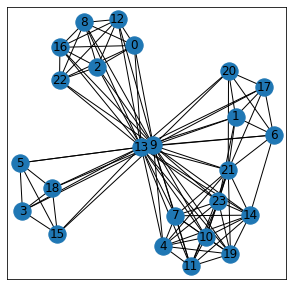

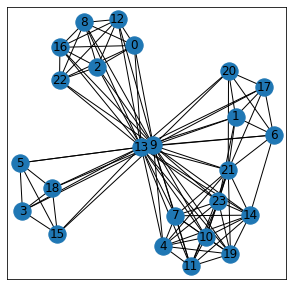

Cluster 6, Indices [563 154]


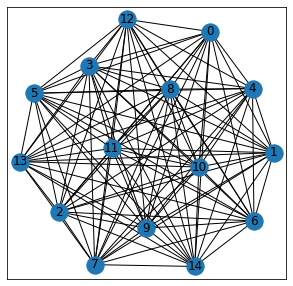

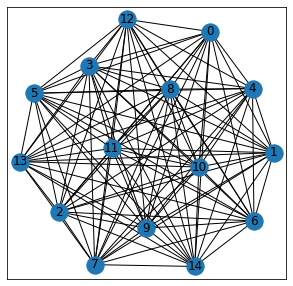

Cluster 7, Indices [523 959]


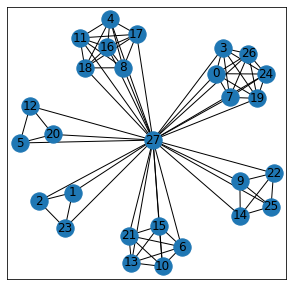

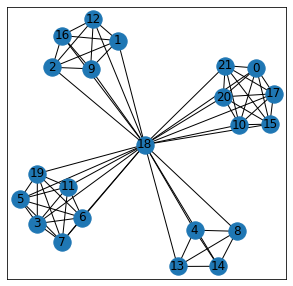

Cluster 8, Indices [782 114]


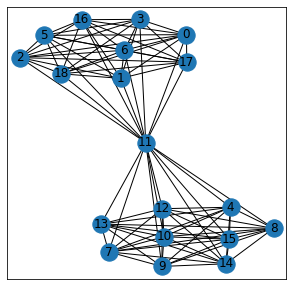

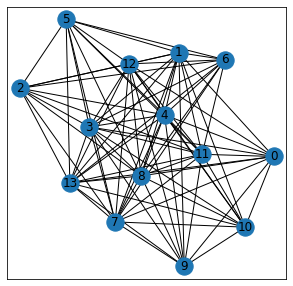

Cluster 9, Indices [166 471]


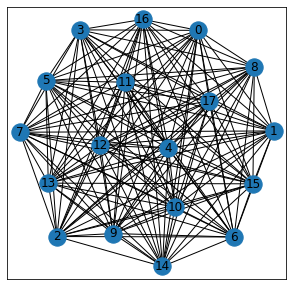

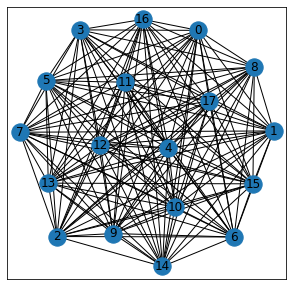

In [19]:
for i, indices in enumerate(nearest_indices):
    print(f"Cluster {i}, Indices {indices}")
    G_selected = select_from_list(G, indices)
    for g_i in G_selected:
        visualize(g_i)